## Análise de Uso de Cartão de Crédito por Descoberta de Subgrupos

A presente análise tem como intuito minerar subgrupos de um conjunto de dados de uso do cartão de crédito para responder as seguintes perguntas:
1. Quem são os clientes com dificuldade de pagar a fatura?

A análise se embasa em um conjunto de dados que registra o uso do cartão de crédito pelas seguintes variáveis:

**Variáveis de Identificação**
* **ID do Cliente (CUST_ID)**: Um código único para identificar cada cliente.

**Variáveis de Saldo e Limite**
* **Saldo Atual (BALANCE)**: O valor total restante na conta do cliente, disponível para compras.
* **Frequência de Atualização do Saldo (BALANCE_FREQUENCY)**: Indica com que frequência o saldo da conta é atualizado. Um valor próximo de 1 significa que o saldo é atualizado constantemente, enquanto 0 indica poucas atualizações.
* **Limite de Crédito (CREDIT_LIMIT)**: O valor máximo de crédito que o cliente possui em seu cartão.

**Variáveis de Compras**
* **Valor Total de Compras (PURCHASES)**: O valor total de todas as compras realizadas pelo cliente.
* **Compras Únicas (ONEOFF_PURCHASES)**: O valor total das compras feitas de uma só vez (à vista ou em parcela única).
* **Compras Parceladas (INSTALLMENTS_PURCHASES)**: O valor total das compras realizadas em parcelas.
* **Frequência de Compras (PURCHASES_FREQUENCY)**: Com que frequência o cliente realiza compras. 1 indica compras muito frequentes, e 0 indica compras raras.
* **Frequência de Compras Únicas (ONEOFFPURCHASESFREQUENCY)**: Com que frequência o cliente faz compras de uma só vez. 1 indica alta frequência de compras únicas, e 0 indica baixa frequência.
* **Frequência de Compras Parceladas (PURCHASESINSTALLMENTSFREQUENCY)**: Com que frequência o cliente realiza compras parceladas. 1 indica alta frequência de parcelamentos, e 0 indica baixa frequência.
* **Número de Transações de Compra (PURCHASES_TRX)**: A quantidade de vezes que o cliente fez compras (total de transações).

**Variáveis de Adiantamento de Dinheiro (Cash Advance)**
* **Valor de Adiantamento de Dinheiro (CASH_ADVANCE)**: O valor total de dinheiro adiantado (saques) pelo cliente.
* **Frequência de Adiantamento de Dinheiro (CASHADVANCEFREQUENCY)**: Com que frequência o cliente solicita adiantamento de dinheiro.
* **Número de Transações de Adiantamento de Dinheiro (CASHADVANCETRX)**: A quantidade de vezes que o cliente fez adiantamentos de dinheiro.

**Variáveis de Pagamento**
* **Valor Total de Pagamentos (PAYMENTS)**: O valor total pago pelo cliente.
* **Pagamento Mínimo (MINIMUM_PAYMENTS)**: O valor mínimo que o cliente pagou em seus extratos.
* **Porcentagem de Pagamento Total (PRCFULLPAYMENT)**: A porcentagem do valor total da fatura que o cliente pagou. Um valor próximo de 1 significa que o cliente paga a fatura completa frequentemente.

**Variáveis de Tempo de Relacionamento**
* **Tempo de Relacionamento (TENURE)**: O tempo em meses que o cliente possui o serviço de cartão de crédito.

### Pré-processamento dos Dados

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/home/gabriel/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1/CC GENERAL.csv', index_col='CUST_ID')
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


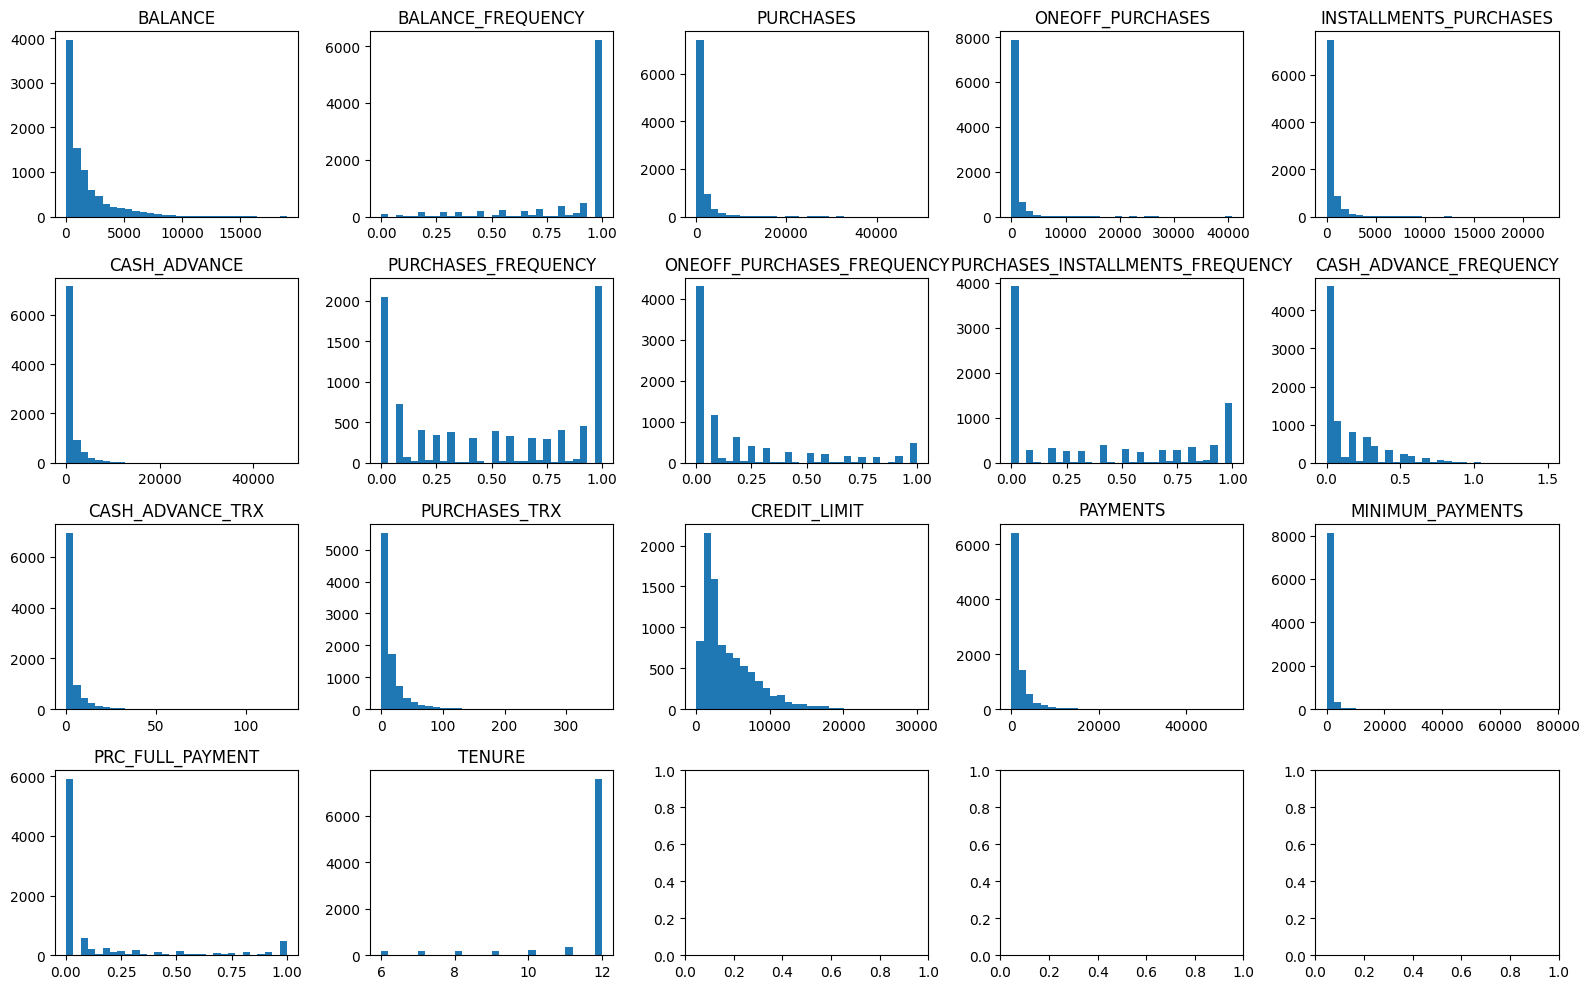

In [22]:
n_cols=5
n_rows = (len(df.columns) - 1) // n_cols + 1

fig,axes=plt.subplots(ncols=n_cols,nrows=n_rows, figsize=(16,10))
for i, (column, ax) in enumerate(zip(df.columns, axes.flatten())):
    df[column].plot(kind='hist', ax=ax, bins=30)
    ax.set_title(column)
    ax.set_ylabel('')


plt.tight_layout()
plt.show()

* Subgrupos são mais fáceis de interpretar com seletores categóricos.
* As colunas numéricas são discretizadas utilizando quartis, um método que lida bem com a assimetria (skewness) das distribuições das colunas.

In [23]:
df_binned = df.drop(columns=['CUST_ID'], errors='ignore')
df_binned = df.fillna(df.median(numeric_only=True))

numeric_cols = df_binned.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    bin_col = f'{col}_BIN'
    try:
        df_binned[bin_col] = pd.qcut(df[col], q=4, labels=['low', 'med_low', 'med_high', 'high'])
    except ValueError:
        print(f"Skipping {col} - too few unique values to bin")

# df_binned = df_binned[[col for col in df_binned.columns if col.endswith('_BIN')]]


Skipping BALANCE_FREQUENCY - too few unique values to bin
Skipping ONEOFF_PURCHASES - too few unique values to bin
Skipping INSTALLMENTS_PURCHASES - too few unique values to bin
Skipping CASH_ADVANCE - too few unique values to bin
Skipping ONEOFF_PURCHASES_FREQUENCY - too few unique values to bin
Skipping PURCHASES_INSTALLMENTS_FREQUENCY - too few unique values to bin
Skipping CASH_ADVANCE_FREQUENCY - too few unique values to bin
Skipping CASH_ADVANCE_TRX - too few unique values to bin
Skipping PRC_FULL_PAYMENT - too few unique values to bin
Skipping TENURE - too few unique values to bin


### Descoberta de Subgrupos

**Pergunta 1**: quem são os clientes com dificuldade de pagar a fatura?

O primeiro passo da análise é definir uma nova variável para o conjunto de dados que capture essa noção.

In [24]:
df_binned['MIN_PAY_RATIO_HIGH'] = (df['MINIMUM_PAYMENTS'] / (df['PAYMENTS'])) > 0.9

Os subgrupos podem ser descritos pelas seguintes variáveis:

**Categóricas**:
- BALANCE_BIN
- PURCHASES_BIN
- CREDIT_LIMIT_BIN
- PAYMENTS_BIN
- TENURE

**Contínuas**:
- BALANCE_FREQUENCY
- PURCHASES_FREQUENCY
- ONEOFF_PURCHASES_FREQUENCY
- PURCHASES_INSTALLMENTS_FREQUENCY
- CASH_ADVANCE_FREQUENCY
- PRC_FULL_PAYMENT

In [25]:
import sys
sys.path.append('../pysubgroup/src/')
import pysubgroup as ps

target = ps.BinaryTarget('MIN_PAY_RATIO_HIGH', True)
categorical_columns = [col for col in df_binned.columns if col.endswith('_BIN')] + ['TENURE']
continuous_columns = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']
search_df = df_binned[categorical_columns + continuous_columns + ['MIN_PAY_RATIO_HIGH']]
selectors = ps.create_selectors(search_df, ignore=['MIN_PAY_RATIO_HIGH'])
task = ps.SubgroupDiscoveryTask(
    search_df,
    target,
    selectors,
    result_set_size=10,
    depth=3,
    qf=ps.WRAccQF()
)
result = ps.BeamSearch().execute(task)

/home/gabriel/cursos/ufmg/aprendizado-descritivo/aprendizado-descritivo-2025.1/../pysubgroup/src/pysubgroup/binary_target.py:508: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


In [26]:
for (quality, subgroup) in result.to_descriptions():
    print(f"{quality:.3f} --> {subgroup}")

0.096 --> BALANCE_FREQUENCY>=1.0 AND PRC_FULL_PAYMENT: [0.0:0.08[
0.091 --> PRC_FULL_PAYMENT: [0.0:0.08[
0.087 --> MINIMUM_PAYMENTS_BIN=='high' AND PRC_FULL_PAYMENT: [0.0:0.08[
0.083 --> BALANCE_FREQUENCY>=1.0 AND PRC_FULL_PAYMENT: [0.0:0.08[ AND TENURE>=12
0.083 --> MINIMUM_PAYMENTS_BIN=='high'
0.080 --> BALANCE_FREQUENCY>=1.0 AND MINIMUM_PAYMENTS_BIN=='high' AND PRC_FULL_PAYMENT: [0.0:0.08[
0.077 --> BALANCE_FREQUENCY>=1.0 AND MINIMUM_PAYMENTS_BIN=='high'
0.076 --> MINIMUM_PAYMENTS_BIN=='high' AND PRC_FULL_PAYMENT: [0.0:0.08[ AND TENURE>=12
0.073 --> MINIMUM_PAYMENTS_BIN=='high' AND TENURE>=12
0.072 --> BALANCE_FREQUENCY>=1.0 AND MINIMUM_PAYMENTS_BIN=='high' AND TENURE>=12


É importante para solidificar a análise conseguir visualizar esses subgrupos.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

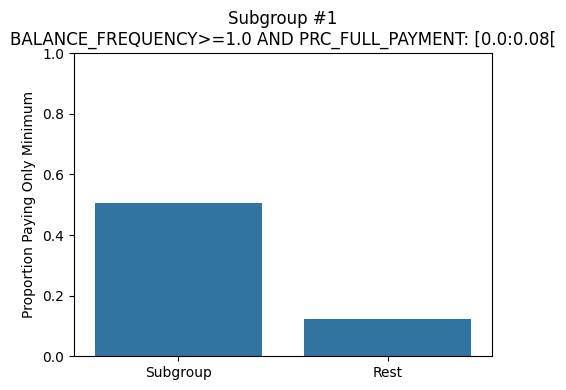

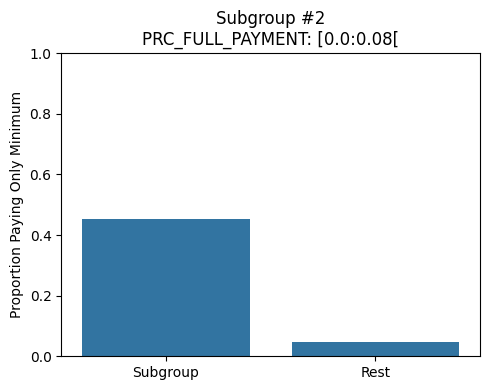

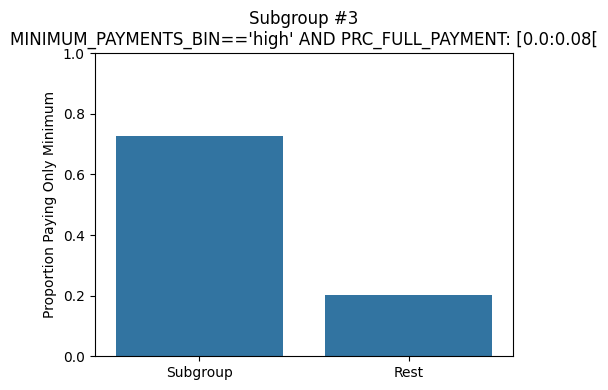

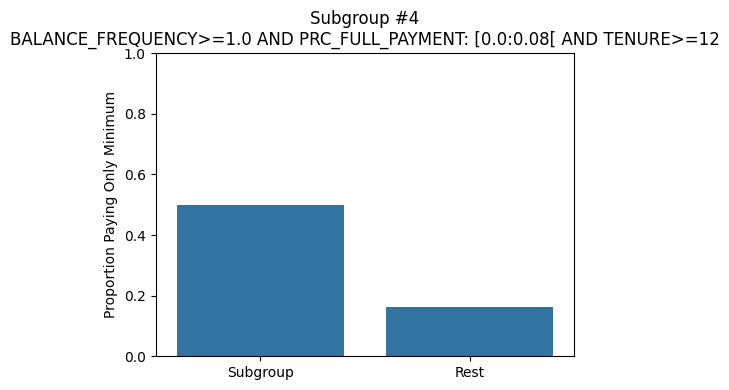

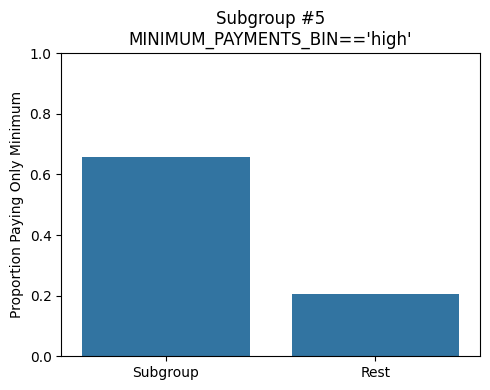

In [31]:
for i, (quality, subgroup) in enumerate(result.to_descriptions()[:5]):
    mask = subgroup.covers(search_df)
    subgroup_size = mask.sum()
    
    target_rate_subgroup = df_binned.loc[mask, 'MIN_PAY_RATIO_HIGH'].mean()
    target_rate_rest = df_binned.loc[~mask, 'MIN_PAY_RATIO_HIGH'].mean()
    
    plt.figure(figsize=(5, 4))
    sns.barplot(x=["Subgroup", "Rest"], y=[target_rate_subgroup, target_rate_rest])
    plt.ylim(0, 1)
    plt.ylabel("Proportion Paying Only Minimum")
    plt.title(f"Subgroup #{i+1}\n{str(subgroup)}")
    plt.tight_layout()
    plt.show()


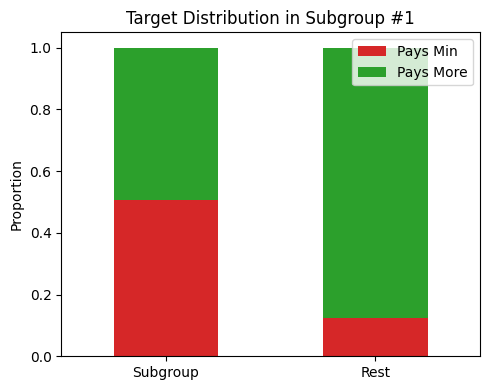

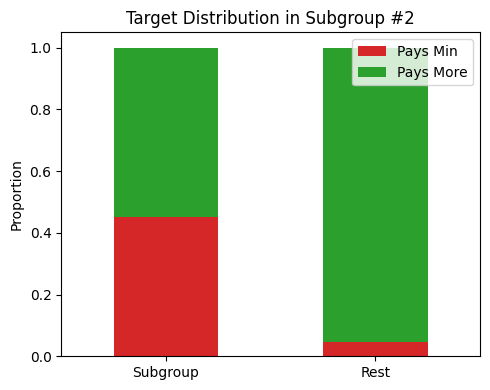

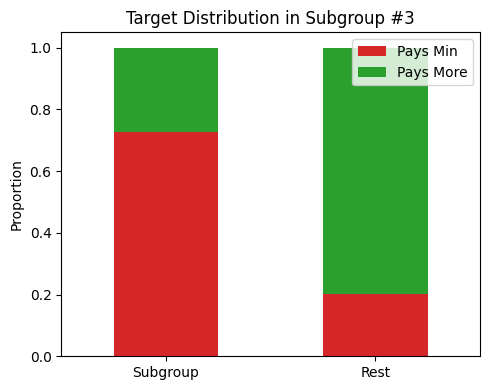

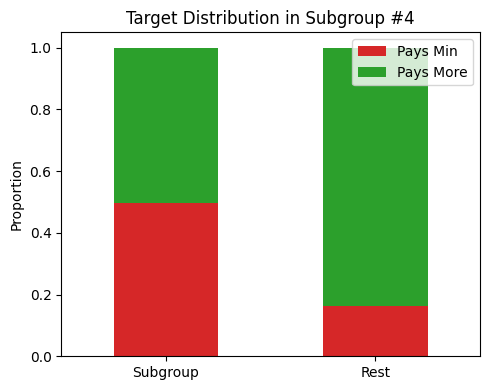

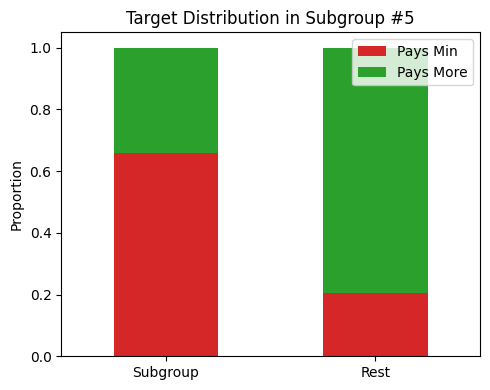

In [32]:
for i, (quality, subgroup) in enumerate(result.to_descriptions()[:5]):
    mask = subgroup.covers(search_df)
    
    counts = pd.Series(df_binned.loc[mask, 'MIN_PAY_RATIO_HIGH']).value_counts(normalize=True)
    rest_counts = pd.Series(df_binned.loc[~mask, 'MIN_PAY_RATIO_HIGH']).value_counts(normalize=True)
    
    subgroup_dist = [counts.get(True, 0), counts.get(False, 0)]
    rest_dist = [rest_counts.get(True, 0), rest_counts.get(False, 0)]
    
    df_plot = pd.DataFrame({
        'Subgroup': subgroup_dist,
        'Rest': rest_dist
    }, index=['Pays Min', 'Pays More'])

    df_plot.T.plot(kind='bar', stacked=True, figsize=(5, 4), color=['#d62728', '#2ca02c'])
    plt.title(f"Target Distribution in Subgroup #{i+1}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


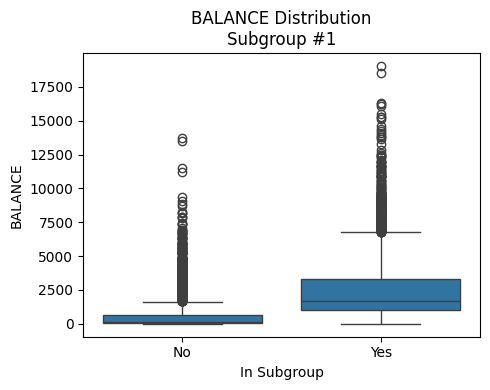

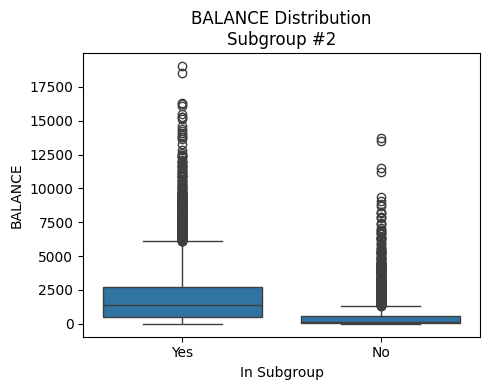

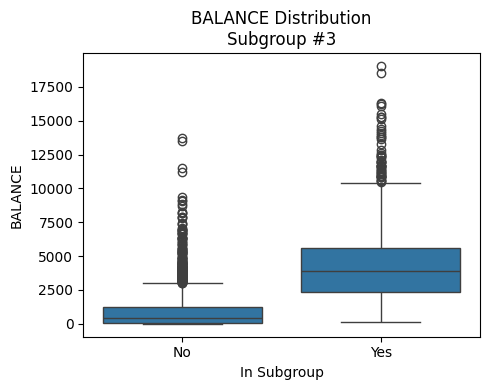

In [34]:
feature_to_plot = 'BALANCE'  # or 'CREDIT_LIMIT', etc.

for i, (quality, subgroup) in enumerate(result.to_descriptions()[:3]):
    mask = pd.Series(subgroup.covers(search_df), index=search_df.index)
    
    df_box = df_binned[[feature_to_plot]].copy()
    df_box['In Subgroup'] = mask.map({True: 'Yes', False: 'No'})
    
    plt.figure(figsize=(5, 4))
    sns.boxplot(x='In Subgroup', y=feature_to_plot, data=df_box)
    plt.title(f"{feature_to_plot} Distribution\nSubgroup #{i+1}")
    plt.tight_layout()
    plt.show()
